# **Lab experience #8 (STUDENTS): Anomaly Detection using proximity-based approaches**

This eighth lab session aims **to spot anomalies using proximity-based approaches**. This lab session refers to all Prof. Stella's lectures on "Introduction to anomaly detection" and "Nearest neighbor based anomaly detection".

In this lab session, you will **re-use code already developed in the past labs** and discover some new tools from sklearn, particularly [sklearn.neighbors](https://scikit-learn.org/stable/modules/neighbors.html).

**Try two main point-anomaly detection algorithms based on k-th nearest neighborhood**. Idenfity outliers with NN and LOF. Remove them, and then apply clustering (choose one among k-means++, hiearchical clustering, DBSCAN).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# **Step 1**: Data loading, visual inspection, and scaling

In [2]:
##### --- 1. LOAD DATA --- ######
# Load the dataset
X = np.load('Dataset_lab08.npy')
[N,M] = np.shape(X)

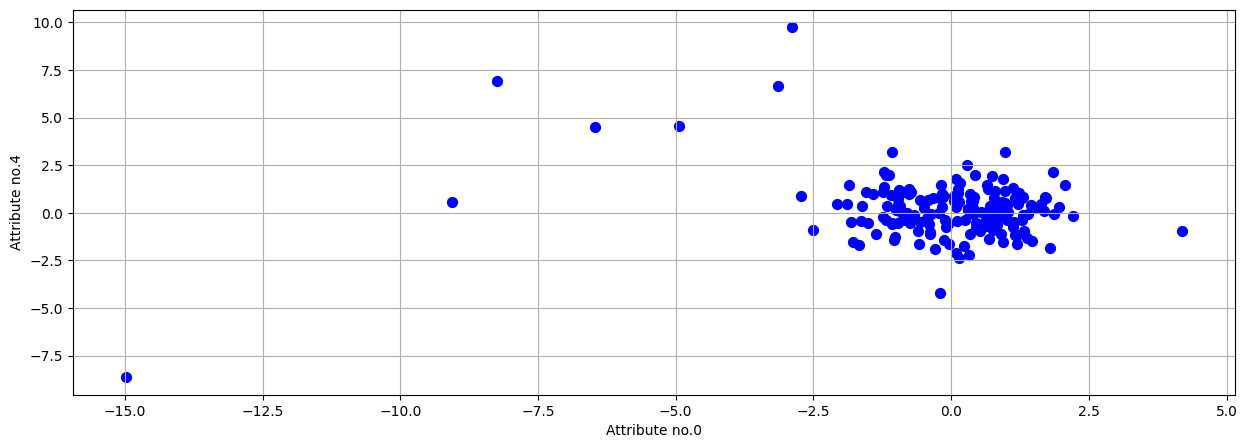

In [9]:
# Visualize the dataset and its proximity matrix
#
PAL = ['blue', 'green', 'red', 'yellow', 'orange', 'purple', 'magenta', 'cyan', 'brown']
# Visualization(s) of the dataset
fig1 = plt.figure(figsize=(15,5))
feat1 = 0
feat2 = 4
scatter_clustering_solution(X, feat1, feat2, np.zeros(N), PAL, fig1)
plt.show()

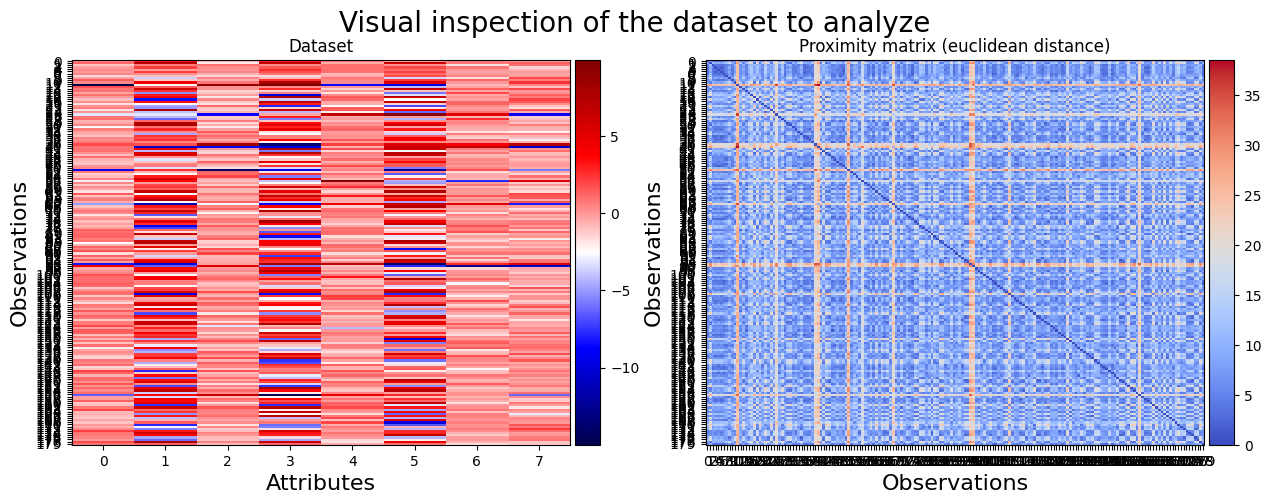

In [10]:
distance_metric = 'euclidean'
PM              = proximity_matrix(X, distance_metric)

# 3. Plot the proximity matrix as an image (you can add a subplot to fig1)
plt.style.use('default')
from mpl_toolkits.axes_grid1 import make_axes_locatable   #to adjust the colorbar

fig2 = plt.figure(figsize=(15,5))
fig2.suptitle('Visual inspection of the dataset to analyze', fontsize=20)


# Plot 1: 2D image of the entire dataset
ax1 = fig2.add_subplot(121)
im1 = ax1.imshow(X, interpolation='nearest', aspect='auto', cmap='seismic')

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im1, cax=cax)

ax1.set_xlabel('Attributes', fontsize=16)
ax1.set_xticks(np.arange(0, M, step=1))     #ALTERNATIVE: plt.xticks(np.arange(3), ['1', '2', '3'])
ax1.set_ylabel('Observations', fontsize=16)
ax1.set_yticks(np.arange(0, N, step=1))
ax1.title.set_text('Dataset')


# Plot 2: proximity matrix
ax2 = fig2.add_subplot(122)
im2 = ax2.imshow(PM, interpolation='nearest', aspect='auto', cmap='coolwarm')

divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im2, cax=cax)

ax2.set_xlabel('Observations', fontsize=16)
ax2.set_xticks(np.arange(0, N, step=1))
ax2.set_ylabel('Observations', fontsize=16)
ax2.set_yticks(np.arange(0, N, step=1))
ax2.title.set_text('Proximity matrix (%s distance)' % distance_metric)

plt.show()

PCA: explained variation per principal component: [0.55 0.15]

Applying tSNE...


/tmp/ipykernel_84443/1091745415.py:40: UserWarning: The palette list has more values (9) than needed (1), which may not be intended.
  sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1], ax=ax1, hue=LABELS, palette=PAL)
/tmp/ipykernel_84443/1091745415.py:47: UserWarning: The palette list has more values (9) than needed (1), which may not be intended.
  sns.scatterplot(x=tsne_results[:,0], y=tsne_results[:,1], ax=ax2, hue=LABELS, palette=PAL)


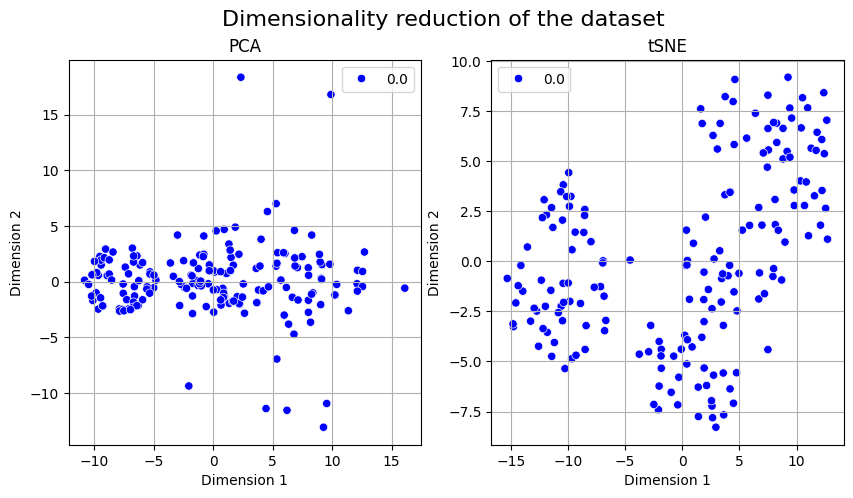

In [11]:
PCA_tSNE_visualization(X, NCOMP=2, LABELS=np.zeros(N), PAL=PAL)

In [12]:
##### --- 2. SCALING --- ######
# Initialize the scaler you want to use: MinMaxScaler(), StandardScaler(), RobustScaler(), Normalizer()
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer
scaler = StandardScaler()

# Apply the scaling to data
X_transformed = scaler.fit_transform(X)

PCA: explained variation per principal component: [0.27 0.19]

Applying tSNE...


/tmp/ipykernel_84443/1091745415.py:40: UserWarning: The palette list has more values (9) than needed (1), which may not be intended.
  sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1], ax=ax1, hue=LABELS, palette=PAL)
/tmp/ipykernel_84443/1091745415.py:47: UserWarning: The palette list has more values (9) than needed (1), which may not be intended.
  sns.scatterplot(x=tsne_results[:,0], y=tsne_results[:,1], ax=ax2, hue=LABELS, palette=PAL)


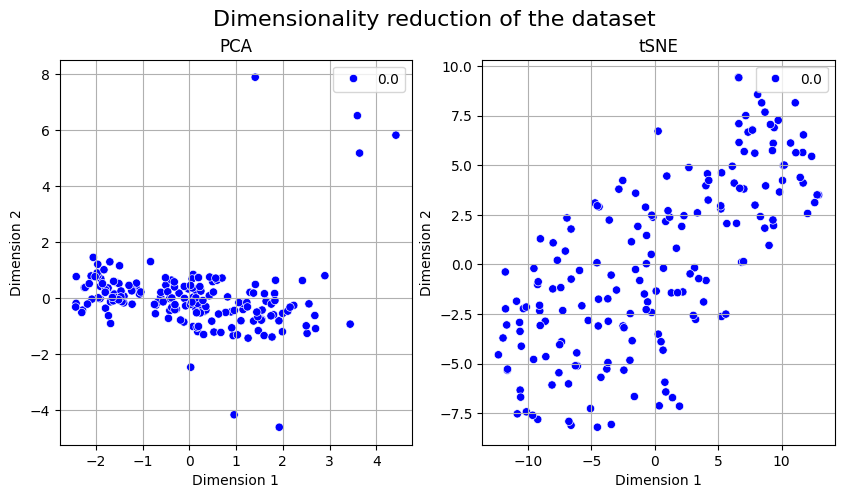

In [13]:
# Visualize the dataset and its proximity matrix AFTER SCALING
#
PCA_tSNE_visualization(X_transformed, NCOMP=2, LABELS=np.zeros(N), PAL=PAL)

# **Step 2**: Investigation on outliers using Nearest Neighbors (NN)



Hint:

[NN](https://scikit-learn.org/stable/modules/neighbors.html) see section 1.6.1.1. "Finding the Nearest Neighbors" and also check previous lab solutions (e.g., Lab7)

```
i. compute distance of all data points to their k-th neighbors (d_k)
ii. sort the d_k distances in ascending order
iii. compute the average (or median) distance among all d_k distances
iv. the top n% data points having d_k largest are defined as outliers

Hyperparameters to set:
k = order of the neighborhood
n = percentage of data points (over the entire dataset) expected to be outliers.
```

**Steps:**
- Apply the algorithm
- Apply the outlier discovery method, count the outliers, and label them.
- Remove the outliers from the dataset, obtaining a reduced dataset (X_red_NN).

In [14]:
# !pip install kneed
# Apply KNEE METHOD to decide the optimal candidate for the eps parameter
from kneed import KneeLocator
from sklearn.neighbors import kneighbors_graph as knn
from sklearn.neighbors import NearestNeighbors

neighborhood_order = 10
neigh = NearestNeighbors(n_neighbors=neighborhood_order)
neigh.fit(X_transformed)
distances, indices = neigh.kneighbors(X_transformed)
sorted_distances = np.sort(distances[:, neighborhood_order - 1], axis=0)


i = np.arange(len(sorted_distances))
knee = KneeLocator(i, sorted_distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')


In [15]:
# Apply the algorithm
#
knee_x = knee.knee
knee_y = knee.knee_y    # OR: distances[knee.knee]
print('The estimated best eps value is = %.2f' % knee_y)

The estimated best eps value is = 1.97


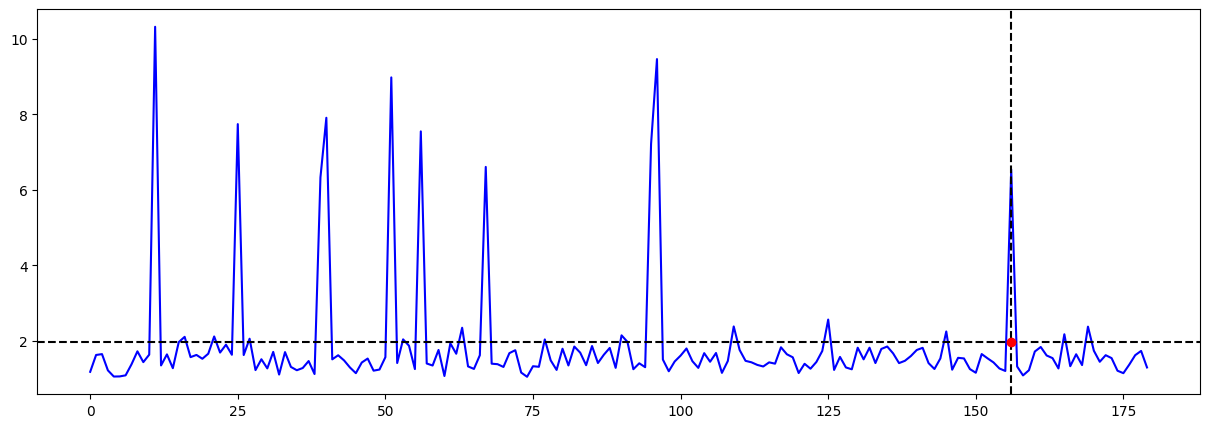

In [16]:
# Plot NON-SORTED distances and the knee curve
#

plt.figure(figsize=(15,5))
plt.plot(distances[:, neighborhood_order - 1], 'b')
plt.axvline(x=knee_x, color='k', linestyle='--')
plt.axhline(y=knee_y, color='k', linestyle='--')
plt.plot((knee_x), (knee_y), 'o', color='r')
plt.show()

In [17]:
# Identify the outliers, assign labels, count their number
#
for value in distances[:, neighborhood_order - 1]:
    if value > knee_y+1:
        print('Outlier detected with distance = %.2f' % value)

Outlier detected with distance = 10.32
Outlier detected with distance = 7.74
Outlier detected with distance = 6.33
Outlier detected with distance = 7.91
Outlier detected with distance = 8.98
Outlier detected with distance = 7.55
Outlier detected with distance = 6.61
Outlier detected with distance = 7.21
Outlier detected with distance = 9.46
Outlier detected with distance = 6.54


PCA: explained variation per principal component: [0.27 0.19]

Applying tSNE...


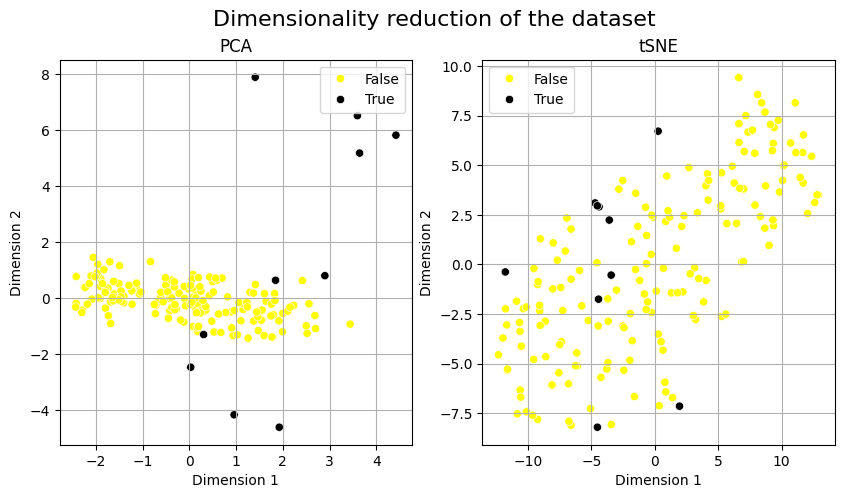

In [18]:
# Visualization of outliers using 2D scatterplot or PCA/tSNE plot (use BLACK for OUTLIERS, yellow for inliers)
#
PCA_tSNE_visualization(X_transformed, NCOMP=2, LABELS=(distances[:, neighborhood_order - 1] > knee_y+1), PAL=['yellow', 'black'])

In [19]:
# Remove rows containing outliers, obtaining X_red
X_red_NN = X_transformed[distances[:, neighborhood_order - 1] <= knee_y+1]

# **Step 3**: Investigation on outliers using Local Outlier Factor (LOF)


Hint:

[LOF](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html#sklearn.neighbors.LocalOutlierFactor) [and also slide no.8 and [WIki](https://en.wikipedia.org/wiki/Local_outlier_factor)]. Here, you don't have to manually implement the algorithm, but only to correctly use the sklearn package to obtain LOF.

```
Locality is given by k-nearest neighbors, whose distance is used to estimate the local density. By comparing the local density of a sample to the local densities of its neighbors, one can identify samples that have a substantially lower density than their neighbors.
These are considered outliers.

For each data point (A) compute the distance to the kth nearest neighbor (d_k)

i. identify the k-th neighborhood of the data point A. Note: for each data point A, you will find a |N_k(A)| points in its k-th neighborhood (|N_k(A)| is indicated as MinPts in Prof. Stella's slides).
ii. compute the average reachability distance to A (average reach_dist_k_AB across all neighbors of A in N_k(A)).
iii. compute the local reachability density (lrd_k) of data point A as the inverse of the average reach_dist_k_AB.
iv. compute LOF(A) as the ratio of the average local reachability density of A's k-nearest neighbors and local reachability density of the data point A.

Hyperparameters to set:
n_neighbors = number of neighbors to consider in N_k(A)
metric = 'minkowski' (with p = 2) as default (i.e., euclidean metric)
contamination = the proportion of outliers expected in the data set.

Possible outputs:
A has LOF < 1, then A is inlier
A has LOF > 1, then A is outlier (the contamination parameter helps you defining the threshold here)
A has LOF near 1, then A has density similar to its neighbors.



Actually, from the sklearn.neighbors.LocalOutlierFactor documentation:
"The opposite LOF of the training samples. The higher, the more normal.
Inliers tend to have a LOF score close to 1 (negative_outlier_factor_ close to -1),
while outliers tend to have a larger LOF score.".
```

**Steps:**

- Apply the algorithm. Read [documentation.](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html#sklearn.neighbors.LocalOutlierFactor) Particularly,

```
contamination = ‘auto’ or float, default=’auto’
is the amount of contamination of the data set, i.e. the proportion of outliers in the data set.
If ‘auto’, the threshold is determined as in the original paper.
If a float, the contamination should be in the range (0, 0.5].
```

- Apply the outlier discovery method, count the outliers, and label them.
- Remove the outliers from the dataset, obtaining a reduced dataset (X_red_LOF).

In [ ]:
# Apply the algorithm
#

In [ ]:
# Identify the outliers, assign labels, count their number
#

In [ ]:
 # Suggested plot: NON-SORTED distances and LOF values
 #

In [ ]:
# Visualization of outliers using 2D scatterplot or PCA/tSNE plot (use BLACK for OUTLIERS, yellow for inliers)
#

In [ ]:
# Remove rows containing outliers, obtaining X_red
#
X_red_LOF =

# **Step 4**: Check coherence between the two outlier detection methods

**Steps:**
- visualize outliers given by NN and by LOF in the same plot
- compute Rand index on labels

# **Step 5**: Supervised validation (using TRUE labels)

**Steps:**
- visualize outliers given by NN, by LOF and TRUE labels in the same plot
- compute Rand index between each method and the TRUE labels

# **Step 6**: Apply clustering (hierarchical, k-means, or DBSCAN)

Here, apply clustering on X and on X_red (X_red_NN or X_red_LOF) to see the effect of outliers on clustering.

In [ ]:
# Clustering
#
#

In [ ]:
# Validation
#
#

# Utility functions

Re-use the utility functions that you need from previous labs.

In [4]:
# NEW METHOD
def scatter_clustering_solution(X, feat1, feat2, labels, PAL, fighandle):
    plt.figure(fighandle)

    for l in range(0, np.size(labels)):
      if labels[l] == -1:
          # Plot noise points in black with cross marker
          plt.scatter(X[l, feat1], X[l, feat2], c='k', marker='x', s=50) #, label='Noise')
      else:
          # Plot points in current cluster color
          plt.scatter(X[l, feat1], X[l, feat2], c=PAL[int(labels[l])], s=50)

    plt.xlabel('Attribute no.%d' % feat1)
    plt.ylabel('Attribute no.%d' % feat2)
    plt.grid('on')
    # plt.show()

In [5]:
# [FROM SOLUTION OF PREVIOUS LABS] THIS IS A **METHOD** TO COMPUTE THE PROXIITY MATRIX

def proximity_matrix(data, distance_metric):

  '''
  INPUT
  data             - dataset for which to compute the proximity matrix
  distance_metric  - distance metric to use in the computation. You can choose one among the following: 'euclidean', 'minkowski', 'mahalanobis',  'hamming'/'matching', 'jaccard', 'cosine', 'correlation'.
  '''

  '''
  OUTPUT
  PM: the square proximity matrix
  '''

  # Proximity matrix: to have an idea of how "similar" are the objects in the dataset
  from scipy.spatial.distance import pdist as pdist
  from scipy.spatial.distance import squareform as sf

  PM = pdist(X, metric=distance_metric)
  PM = sf(PM).round(2)

  return PM

In [6]:
# [FROM SOLUTION OF LAB#4] THIS IS A **METHOD** THAT YOU CAN USE IN THE NEXT LAB SESSIONS TO find visualize data in 2D with clusters in different colours

def PCA_tSNE_visualization(data2visualize, NCOMP, LABELS, PAL):

  '''
  INPUT
  data2visualize    - data matrix to visualize
  NCOMP             - no. of components to decompose the dataset during PCA
  LABELS            - labels given by the clustering solution
  PAL               - palette of colours to distinguish between clusters
  '''

  '''
  OUTPUT
  Two figures: one using PCA and one using tSNE
  '''


  # PCA
  from sklearn.decomposition import PCA
  pca = PCA(n_components=NCOMP)
  pca_result = pca.fit_transform(data2visualize)
  print('PCA: explained variation per principal component: {}'.format(pca.explained_variance_ratio_.round(2)))

  # tSNE
  from sklearn.manifold import TSNE
  print('\nApplying tSNE...')
  np.random.seed(100)
  tsne = TSNE(n_components=2, verbose=0, perplexity=20, n_iter=300)
  tsne_results = tsne.fit_transform(data2visualize)


  # Plots
  fig1000 = plt.figure(figsize=(10,5))
  fig1000.suptitle('Dimensionality reduction of the dataset', fontsize=16)


  # Plot 1: 2D image of the entire dataset
  ax1 = fig1000.add_subplot(121)
  sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1], ax=ax1, hue=LABELS, palette=PAL)
  ax1.set_xlabel('Dimension 1', fontsize=10)
  ax1.set_ylabel('Dimension 2', fontsize=10)
  ax1.title.set_text('PCA')
  plt.grid()

  ax2= fig1000.add_subplot(122)
  sns.scatterplot(x=tsne_results[:,0], y=tsne_results[:,1], ax=ax2, hue=LABELS, palette=PAL)
  ax2.set_xlabel('Dimension 1', fontsize=10)
  ax2.set_ylabel('Dimension 2', fontsize=10)
  ax2.title.set_text('tSNE')
  plt.grid()
  plt.show()

In [7]:
# [FROM SOLUTION OF LAB#2] THIS IS A **METHOD** THAT YOU CAN USE TO find cluster centers

def find_cluster_centers(data, K, labels):

  '''
  INPUT
  data    - data matrix for which to compute the proximity matrix
  K       - the expected number of clusters
  labels  - predicted labels from the clustering solution applied to data
  '''

  '''
  OUTPUT
  cluster_centers   - cluster centres from the clustering solution applied to data
  '''

  # Initialize the output
  cluster_centers = np.zeros((K, np.shape(data)[1]))   # np.shape(data)[1] = no. of attributes

  print("%d centroids are being computed, as we have %d clusters." % (K, K) )

  for k in range(0, K):
    ind = np.array( np.where( labels == k ) )
    cluster_points = data[ind, :][0]
    cluster_centers[k,:] = np.mean(cluster_points, axis=0) # cluster_points.mean(axis=0)
    print("The centroid of cluster %d has coordinates: " % (k), *cluster_centers[k,:].round(2))

  return cluster_centers

In [8]:
# [FROM SOLUTION OF LAB#3] THIS IS A **METHOD** THAT YOU CAN USE IN THE NEXT LAB SESSIONS TO compute the intra- and inter-cluster distances

def intra_inter_cluster_distances(data, K, labels, cluster_centers, distance_metric):

  '''
  INPUT
  data            - data matrix for which to compute the proximity matrix
  K               - the expected number of clusters
  labels          - predicted labels from the clustering solution applied to data
  cluster_centers - cluster centres from the clustering solution applied to data
  distance_metric - metric to compute the distances within and between clusters. Here, you use the same metric for both measurements (but it might be possible to use two different metrics)
  '''

  '''
  OUTPUT
  d               - intra-cluster distance
  D               - inter-cluster distances
  '''

  from scipy.spatial.distance import pdist as pdist
  from scipy.spatial.distance import squareform as sf


  # Intra-cluster distances (average over all pairwise distances) ----------------- NOTE: bug fixed here!
  PM = pdist(data, metric=distance_metric)
  PM = sf(PM).round(2)

  d = np.zeros(K)
  for k in range(K):
    ind = np.array( np.where(labels == k ) )
    for r in range(ind.size):
      d[k] = d[k] + np.sum( PM[ [ind[0][r]], [ind] ] )
    d[k] = d[k]/2                                          # not to consider pairs of pair-wise distance between objects twice (the PM is symmetric)
    d[k] = d[k]/( (ind.size*(ind.size-1)) / 2 )            # to compute the average among N*(N-1)/2 possible unique pairs
  print("The intra-cluster distance of the clusters are: ", d.round(2))


  # Inter-cluster distance ---------------------------------------------------
  D = pdist(cluster_centers, metric=distance_metric)
  D = sf(D).round(2)
  print("\nAll pair-wise inter-cluster distances:\n", D)

  return d, D

# _This it the end of Lab session #8_ ✅


--------------------------------------------------------------